In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from miestimation import plot_info_plan

In [2]:
from importlib import reload
import miestimation
reload(miestimation)
from miestimation import plot_info_plan

In [3]:
def get_subdirs(setup_idx):
    path = './setup-{}/'.format(setup_idx)
    subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    return subdirs

In [4]:
def get_data(setup_idx, subdirs, estimator, bin_size=0, noise_variance=None):
    path = './setup-{}/'.format(setup_idx)

    epoch_data = []
    mi_xt_data = []
    mi_ty_data = []

    if estimator == 'kde':
        if noise_variance is None:
            suffix = 'kde'
        else:
            suffix = 'kde-{}'.format(noise_variance)
    else:
        suffix = bin_size

    for subdir in subdirs:
        fname = path + subdir + '/mi-{}.npz'.format(suffix)
        data = np.load(fname)
        epochs = data['epochs']
        mi_xt = data['mi_xt_epochs']
        mi_yt = data['mi_ty_epochs']

        sorted_idx = np.argsort(epochs)
        mi_xt = mi_xt[sorted_idx]
        mi_yt = mi_yt[sorted_idx]
        epochs = epochs[sorted_idx]

        epoch_data.append(epochs)
        mi_xt_data.append(mi_xt)
        mi_ty_data.append(mi_yt)

    # epoch_data = np.array(epoch_data)
    # mi_xt_data = np.array(mi_xt_data)
    # mi_ty_data = np.array(mi_ty_data)

    return epoch_data, mi_xt_data, mi_ty_data

def get_loss(setup_idx, subdirs):
    loss_data = []

    for subdir in subdirs:
        path = './setup-{}/'.format(setup_idx)
        fname = path + subdir + '/loss.npz'
        data = np.load(fname)
        loss = data['train_loss']
        loss_data.append(loss)

    return loss_data

In [5]:
def get_windows(loss_data, threshold=0.69):
    repetitions = len(loss_data)
    window_list = []
    for i in range(repetitions):
        window = [0,10000]
        
        if len(loss_data[i]) == 10000:
            window_list.append(window)
            continue

        start = np.argmin( np.abs( loss_data[i] - threshold ) )

        if start >= 1000:
            window = [start-1000, start+9000]

        if window[1] > len(loss_data[i]):
            window = [len(loss_data[i])-10000, len(loss_data[i])]
            
        window_list.append(window)
        
    return window_list

In [6]:
def average_windowed_data(mi_xt_data, mi_ty_data, window_list):
    
    repetitions = len(window_list)

    windowed_mi_xt_data = []
    windowed_mi_ty_data = []
    for i in range(repetitions):
        window = window_list[i]
        windowed_mi_xt =  mi_xt_data[i][window[0]:window[1]]
        windowed_mi_ty =  mi_ty_data[i][window[0]:window[1]]
        
        windowed_mi_xt_data.append( windowed_mi_xt )
        windowed_mi_ty_data.append( windowed_mi_ty )

    windowed_mi_xt_data = np.array(windowed_mi_xt_data)
    windowed_mi_ty_data = np.array(windowed_mi_ty_data)

    epochs = np.arange(1, windowed_mi_xt_data.shape[1] + 1)
    avg_mi_xt_data = np.mean(windowed_mi_xt_data, axis=0)
    avg_mi_ty_data = np.mean(windowed_mi_ty_data, axis=0)

    return epochs, avg_mi_xt_data, avg_mi_ty_data, windowed_mi_xt_data, windowed_mi_ty_data

In [7]:
def average_data(mi_xt_data, mi_ty_data):
    
    epochs = np.arange(1, mi_xt_data.shape[1] + 1)
    avg_mi_xt_data = np.mean(mi_xt_data, axis=0)
    avg_mi_ty_data = np.mean(mi_ty_data, axis=0)

    return epochs, avg_mi_xt_data, avg_mi_ty_data

In [8]:
def pipeline(setup_idx, estimator, subdir_list=np.arange(1,11), bin_size=0, threshold=0.69, noise_variance=None):
    
    path = './setup-{}/'.format(setup_idx)
    
    subdirs = get_subdirs(setup_idx)
    subdirs = [d for d in subdirs if int(d.split('-')[1]) in subdir_list]

    epoch_data, mi_xt_data, mi_ty_data = get_data(setup_idx, subdirs, estimator=estimator, bin_size=bin_size, noise_variance=noise_variance)
    loss_data = get_loss(setup_idx, subdirs)
    window_list = get_windows(loss_data, threshold=threshold)

    epochs, avg_mi_xt_data, avg_mi_ty_data, windowed_mi_xt_data, windowed_mi_ty_data = average_windowed_data(mi_xt_data, mi_ty_data, window_list)

    plot_info_plan(avg_mi_xt_data, avg_mi_ty_data, epochs)
    plt.savefig(path+"info-plan-{}.png".format('kde' if estimator=='kde' else bin_size), dpi=300, bbox_inches="tight")
    plt.show()
    

# Experiments

### Reproduce paper results

Setup 11: full batch

Setup 21: mini-batch and smaller learning rate (looks good)

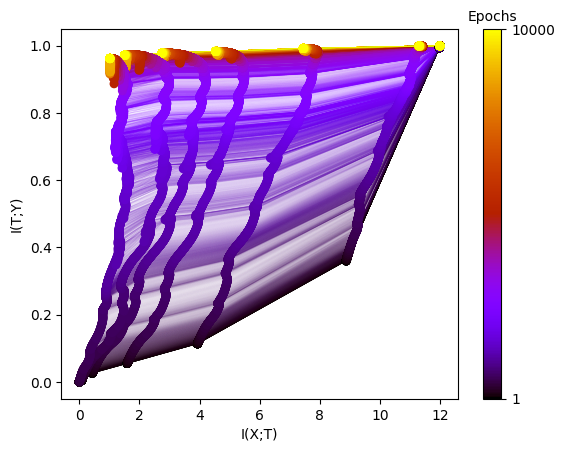

In [9]:
pipeline(setup_idx=11, estimator='kde')

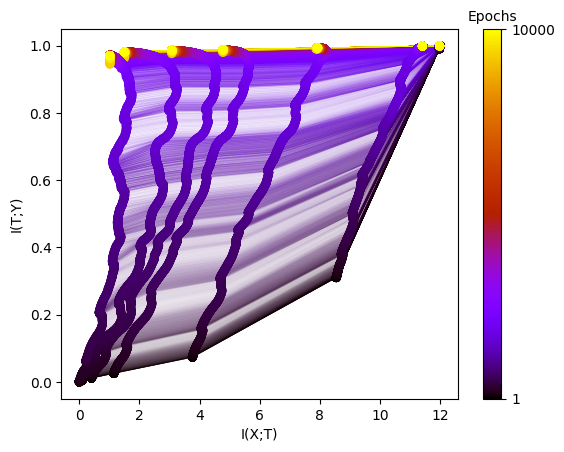

In [15]:
pipeline(setup_idx=21, estimator='kde')

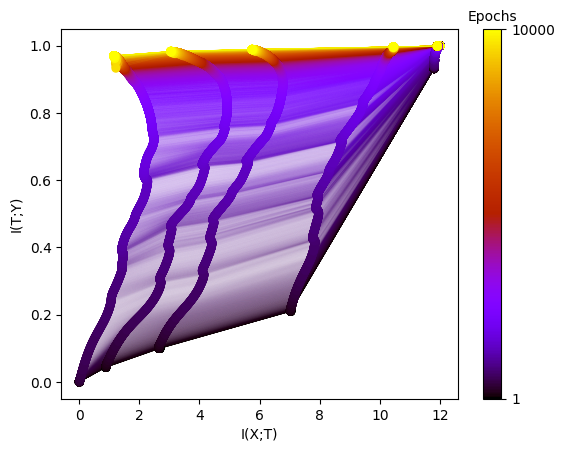

In [11]:
pipeline(setup_idx=31, estimator='kde', noise_variance=0.001)

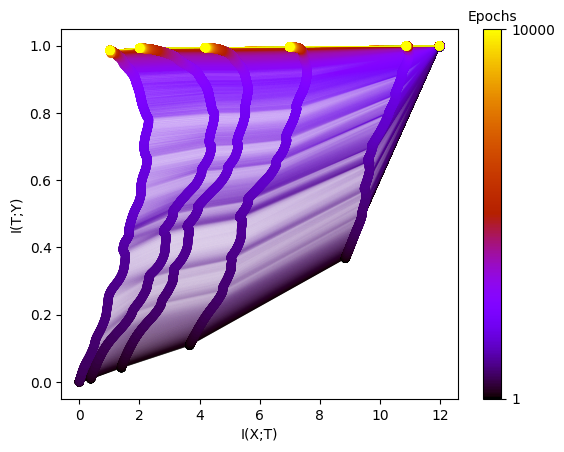

In [9]:
pipeline(setup_idx=41, estimator='kde', noise_variance=0.001)

### ReLU activation

Setup 12: full batch

Setup 22: (looks bad so far)<br>
v1: mini-batch and smaller learning rate<br>
v2: mini-batch

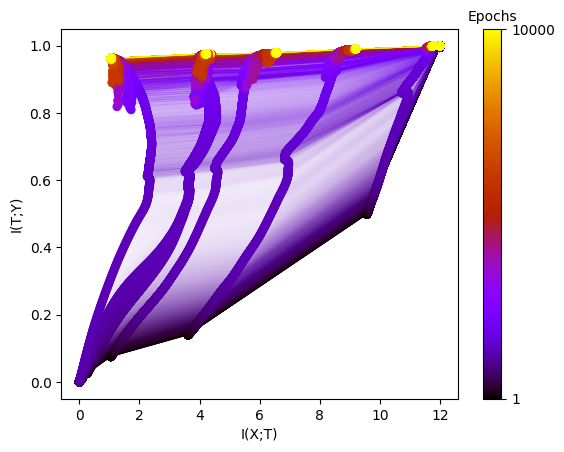

In [10]:
pipeline(setup_idx=12, estimator='kde')

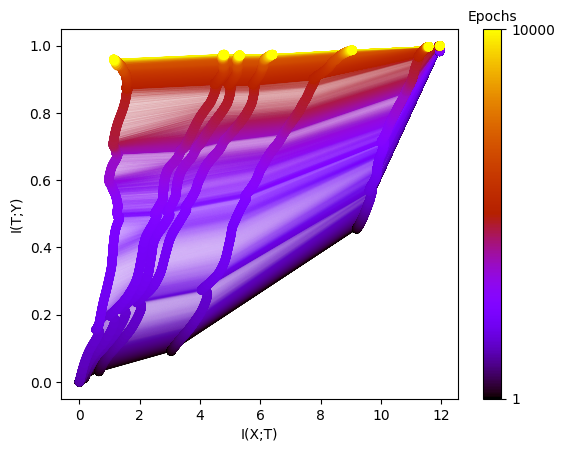

In [10]:
pipeline(setup_idx=42, estimator='kde', noise_variance=0.001)

### Weight decay

- $10^{-4}$

Setup 13: full batch

Setup 23: mini batch

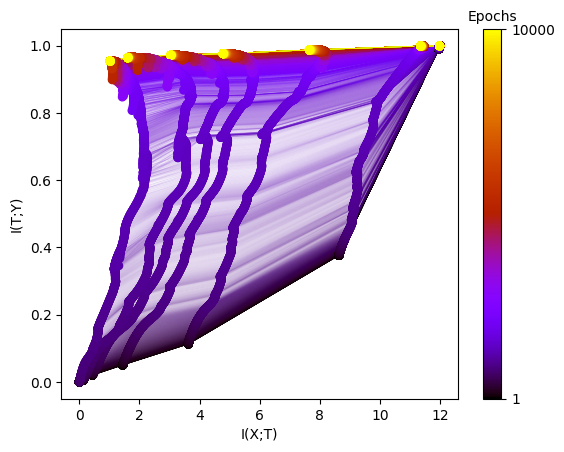

In [11]:
pipeline(setup_idx=13, estimator='kde')

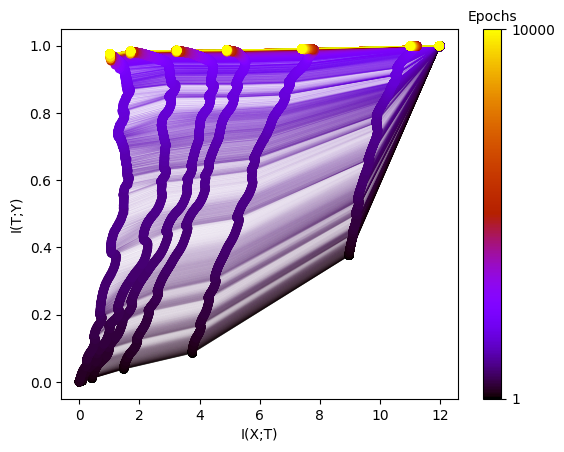

In [25]:
pipeline(setup_idx=23, estimator='kde', noise_variance=0.001)

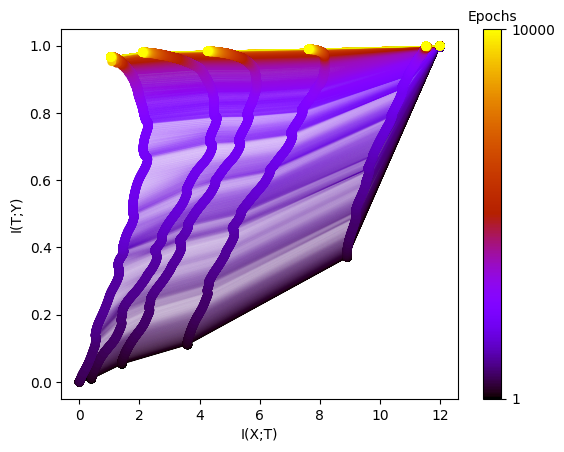

In [11]:
pipeline(setup_idx=43, estimator='kde', noise_variance=0.001)

- $10^{-3}$

Setup 14: full batch

Setup 24: mini batch

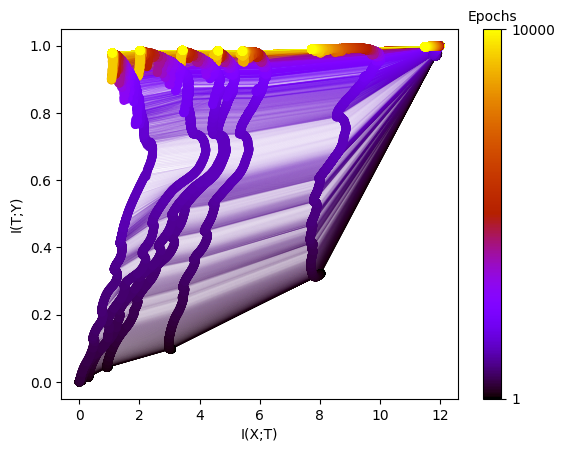

In [12]:
pipeline(setup_idx=14, estimator='kde')

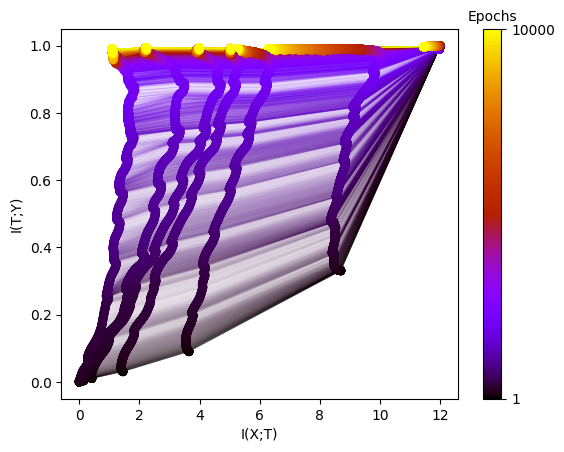

In [9]:
pipeline(setup_idx=24, estimator='kde', noise_variance=0.001)

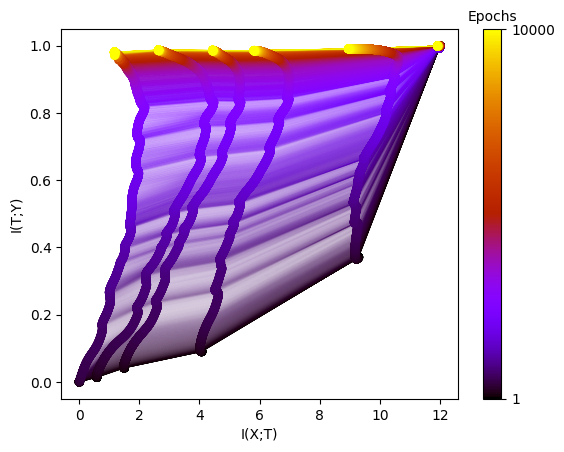

In [12]:
pipeline(setup_idx=44, estimator='kde', noise_variance=0.001)